In [1]:
#-------
#IMPORTS
#-------

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from pylab import title, show
from scipy.constants import e, c, m_e, h, alpha, hbar
from scipy.signal import hilbert


In [59]:
#----------
#PARAMETERS
#----------

#LASER
lambda_0 = 800e-9 #laser wavelength in m
FWHM = 1.19e-5 #Full width at  half max of the gaussian laser (in pi)
w0 = 60.e-5 
ctau = 14.e-6
z0 = 0.e-6
zf = 500.e-6
a0 = 1.2 #The peak amplitude of the laser
n0 = 1.e24

#GAS
initial_energy = 0e3 #initial energy of the ionized electrons (in eV)
element = 'Ar' # Element that is used fo ionization injection (string, use the shortcut, f.e. 'N' for nitrogen)

#IONIZATION ENERGIES
if element == 'N':
	U_G = [14.534,29.600,47.449,77.473,97.890,552.070,667.045]
elif element == 'Ar':
	U_G = [15.760,27.629,40.742,59.812,75.017,91.009,124.319,143.462,422.448,478.684,			538.963,618.260,686.104,755.742,854.772,918.026,4120.887,4426.228]
elif element == 'Kr':
	U_G = [14.000,24.360,26.949,52.547,64.673,78.458,111.001,125.802,230.854,			268.227,307.819,350.312,390.733,446.700,492.303,541.015,591.800,640.512,785.612,833.287,			884.072,936.930,998.079,1050.937,1151.471,1205.261,2927,907,3069.897,3227.434,3380.826]
else:
	print("Choose an available element for ionization injection")

#PLOT SETTINGS
ion_niveau = 12 #The niveau that should get ionized 	


In [60]:
#------------------------------
#CONSTANTS AND OTHER PARAMETERS
#------------------------------


#Physical constants
lambda_c = h/(m_e * c) #compton wavelength
U_H = 13.6 #ionization potential of hydrogen in eV
epsilon_0 = 8.854e-12 #Vacuum permittivity

#Other parameters
k_0 = 1/lambda_0 #wave number of the laser
E_k = (1/e)*k_0*(c**2)*m_e #laser energy
omega_0 = c*k_0 #laser frequency
energy = initial_energy*e 
U_i = U_G[ion_niveau-1]
max_a = a0

In [61]:
#--------------
#LASER PROFILES
#--------------

#OSCILLATING PULSE
def gaussian_profile(max_a, z, r, t, w0, ctau, z0, zf, k_0):

    # Calculate the Rayleigh length

    zr = 0.5*k_0*w0**2
    inv_zr = 1./zr
    inv_ctau2 = 1./ctau**2
    
    
    # Diffraction and stretch_factor
    diffract_factor = 1. - 1j*(z-zf)*inv_zr
    stretch_factor = 1.
    # Calculate the argument of the complex exponential
    exp_argument = 1j*k_0*( c*t + z0 - z )         - r**2 / (w0**2 * diffract_factor)         - 1./stretch_factor * inv_ctau2 * ( c*t  + z0 - z )**2
    # Get the transverse profile
    profile_Eperp = np.exp(exp_argument)         / ( diffract_factor * stretch_factor**0.5 )
    
    return(max_a*profile_Eperp.real )

#ENVELOPE
def gauss_laser(max_a,FWHM,z):
    sigma = FWHM/(np.sqrt(2*np.log(2)))
    laser_a = max_a*np.exp(-(z)**2/(2*sigma**2))
    return(laser_a)

In [72]:
#------------------
#IONIZATION PROCESS
#------------------

#PROBABILITY
def ion_prob(psi):
    
    E_gauss = gaussian_profile(a0, psi,0,0,w0,ctau,z0,zf,k_0) 
    
    amplitude = gauss_laser(a0, FWHM, psi)

	#Keldysh parameter
    gamma_k = (alpha/amplitude)*np.sqrt(U_i/U_H) 
    
	#Calculate the electrical field of the laser (in V/m)
    E_L = 1e2*np.sqrt(2.8e18/(lambda_0*1e6*c*epsilon_0))*E_gauss #Electrical field of the laser in V/m
	
    #Argument of the exponential function
    laser_ion = lambda_0/lambda_c * amplitude**3 *gamma_k**3 * (E_k/(np.sqrt(E_L**2)))
    tunnel_ion = (gamma_k**3 * energy)/(hbar*omega_0)
    
    #Probability
    prob = np.exp(-2/3 * (laser_ion + tunnel_ion))
    
    return(prob)

#IONIZATION DEGREE
def degree(psi):
    n = np.zeros_like(psi+1)
    for i,val in enumerate(psi):
        prob = ion_prob(val)
        if i+1 < len(psi):
            n[i+1]=  n[i]+prob*(n0-n[i])
    return n/n0

def get_min_a(psi):
    prob = np.zeros_like(psi)
    for ii,psi in enumerate(psi):
        prob[ii] = ion_prob(psi)
        min_a = gauss_laser(a0,FWHM,psi)
        if prob[ii] >= 0.01:
            break
    return min_a




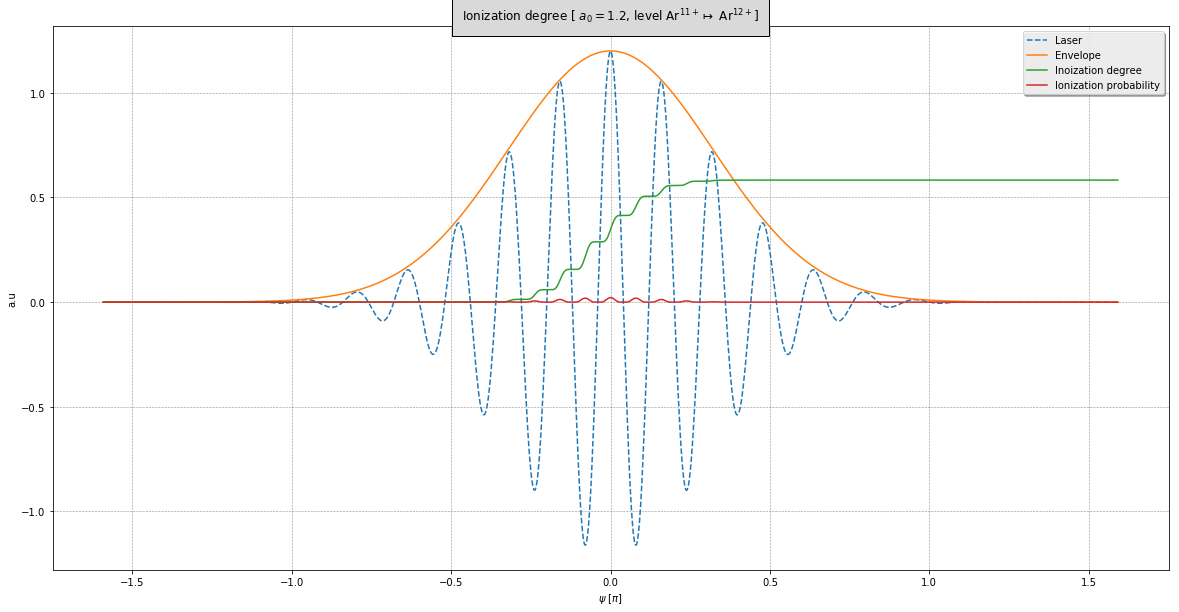

In [73]:
#-----
#PLOTS
#-----

psi = np.linspace(-50e-6,50e-6,1000)

a_ion_min = get_min_a(psi)

### Plot the functions

# Set the size of the plot
fig, ax = plt.subplots(figsize=(20,10))

# Set the labels of the axis
plt.xlabel("$\psi$ [$\pi$]")
plt.ylabel(r"a.u")

ax.grid(which='major', alpha=0.8, color='grey', linestyle='--', linewidth=0.6, animated='True')
ax.grid(which='minor', alpha=0.6, color='grey', linestyle='--', linewidth=0.5, animated='True')



ax.plot(1e5*psi/(np.pi), gaussian_profile(a0, psi, 0, 0, w0, ctau, z0, zf, k_0),linestyle='--', label="Laser")
ax.plot(1e5*psi/np.pi, gauss_laser(a0, FWHM, psi), label="Envelope")
ax.plot(1e5*psi/np.pi, degree(psi), label="Inoization degree")
ax.plot(1e5*psi/np.pi, ion_prob(psi), label="Ionization probability")

#ax.text(0.074, -0.5, 'Measurements:\n\n- max. ionization deegre: '+str("%.2f" % max(degree(psi)*100))+'% \n- max. ionization prob.:    ' +str("%.2f" % max(ion_prob(psi)*100))+'% \n\n- $a_{thres}\, =$ '+str("%.2f" % a_ion_min)+'', bbox={'facecolor': '0.85', 'pad': 10})

# Make the legend 
legend = ax.legend(loc='upper right', shadow=True)


for label in legend.get_texts():
    label.set_fontsize('medium')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
title("Ionization degree [ $a_0 =$"+str(a0)+", level "+str(element)+"$^{"+str(ion_niveau-1)+"+}\mapsto$ "+str(element)+"$^{"+str(ion_niveau)+"+}$]", bbox={'facecolor': '0.85', 'pad': 10})

show()


In [25]:
gauss_laser(a0, FWHM, np.pi)

0.00061257947689802089

In [71]:
degree(psi)

1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+24
1e+2

4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278105e+23
4.16996278

array([  0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+